# SLT-CE-4: Histogram Clustering

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Histogram clustering for unsupervised image segmentation http://ieeexplore.ieee.org/document/784981/
</li>

<li> Lecture Slides 4 https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture04.pdf
</li>
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

## Texture and label map

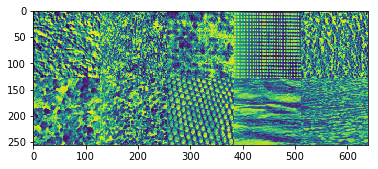

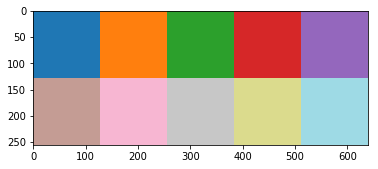

In [3]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)

plt.imshow(texture)
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.show()

## Permuted texture and label map

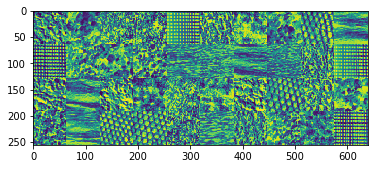

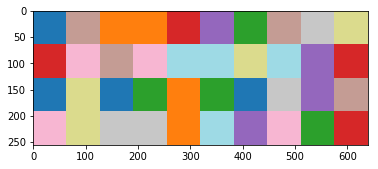

In [4]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
plt.imshow(perm_texture)
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.show()

<h2 style="background-color:#f0b375;">
Problem 0<br>
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: Take a look at the lecture slides, too.
</p>

Put your recap here
Map estimation: $p(y|x)= \frac{p(x|y)p(y)}{p(x)}$  which gets in our case: $\hat{P}(y|c)=\sum_{x:c(x)=x} \dfrac{n(x)\hat{P}(y|x)}{\sum_{x':c(x')=c}n(x')}$<br>
Deterministic annealing estimation: 

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\dots$

<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring.
    You can add more class methods if necessary.
</p>

In [104]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)

    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).

    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """

    def __init__(self, n_clusters=10, n_bins=128, window_size=23, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.centroids = None

    def fit(self, X):
        """Compute HC for input image X

        Compute centroids.        

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            self
        """
        m, n = X.shape
        X_F = np.reshape(X, (m * n, 1))

        # gives Y = (m,n,self.n_bins) <=> for each pixel the histogram
        Y, n_x = self.get_histograms(X)

        # flatten
        Y_F, n_x_F = Y.reshape((m * n, self.n_bins)), n_x.reshape((m*n, 1))
        
        # Code for Maximum a Posteriori estimation
        if self.estimation == "MAP":
            # initialize assignments c(x) = randomly to all clusters
            c_x = np.random.randint(0, self.n_clusters, (m * n, 1))

            # initialize clusters
            self.centroids = np.ones((self.n_clusters, self.n_bins)) / self.n_bins

            # check convergence
            old_c_x = np.ones(self.centroids.shape)
            i_max = 100
            i = 0
            while (not np.all(c_x == old_c_x)) and i < i_max:
                old_c_x = c_x.copy()
                self.update_centroids(Y_F, c_x, n_x_F)
                c_x = self.update_cluster_assignments(Y_F)
                i = i + 1

        elif self.estimation == "DA":
            pass
            # Code for Deterministic Annealing estimation

        return self

    def update_cluster_assignments(self, Y_F):
        return np.argmin(-np.dot(Y_F, np.log(self.centroids).T), axis=1)
    """
        def update_centroids(self, Y_F, c_x, n_x_F):
            self.centroids = np.zeros(self.centroids.shape)
            n_x_by_c = np.zeros((self.n_clusters, 1))
            for c in range(self.n_clusters):
                x_index = (c_x == c).reshape(-1, )
                n_x_by_c[c] = np.sum(n_x_F[x_index])

            for i, x in enumerate(Y_F):
                self.centroids[int(c_x[i])] += Y_F[i] * n_x_F[i] / n_x_by_c[int(c_x[i])]
    """
    def update_centroids(self, Y_F, c_x, n_x_F):
        n_x_by_c = np.zeros((self.n_clusters, 1))

        for c in range(self.n_clusters):
            x_index = (c_x == c).reshape(-1, )
            n_x_by_c[c] = np.sum(n_x_F[x_index])
            self.centroids[c] += np.sum(Y_F[x_index] * n_x_F[x_index],axis=0) / n_x_by_c[c]



    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        m,n = X.shape
        
        # gives Y = (m,n,self.n_bins) <=> for each pixel the histogram
        Y, n_x = self.get_histograms(X)

        # flatten
        Y_F, n_x_F = Y.reshape((m * n, self.n_bins)), n_x.reshape((m*n, 1))
        
        # assignments 
        C = self.update_cluster_assignments(Y_F).reshape((m,n))
        
        return C

    def generate(self, C):
        """Generate a sample image X from a texture label map C.

        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).

        Args:
            C (np.ndarray): Input array with shape (height, width)

        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])

        # Your code goes here
        X = None
        return X

    def get_histograms(self, X):
        m, n = X.shape
        w = self.window_size // 2
        y_x = np.empty((m, n, self.n_bins))
        n_x = np.empty((m, n))
        for i in range(m):
            for j in range(n):

                start_i = i-w if i-w >= 0 else 0
                start_j = j-w if j-w >= 0 else 0
                end_i = i+w+1 if i+w+1 <= m else m
                end_j = j+w+1 if j+w+1 <= n else n

                x = np.arange(start_i, end_i)
                x_len = len(x)
                y = np.arange(start_j, end_j)
                y_len = len(y)
                x = np.repeat(x, y_len)
                y = np.repeat(y.reshape(1, -1), x_len, axis=0).reshape(-1, )

                y_x[i, j], _ = np.histogram(X[x, y], self.n_bins, range=(X.min(), X.max()))
                n_x[i, j] = np.sum(y_x[i, j])
                y_x[i, j] /= n_x[i, j]
        return y_x, n_x

<p style="background-color:#adebad;">
    Create an instance of your HC class with n_clusters = 8 and fit the image texture. Record the execution time.
</p>

In [105]:
%%time
HC = HistogramClustering()
HC.fit(texture)

/home/simi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


CPU times: user 1min 27s, sys: 2.53 s, total: 1min 30s
Wall time: 48.6 s


<h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>

    </ul>
</p>

In [125]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 44.6 s, sys: 201 ms, total: 44.9 s
Wall time: 44.9 s


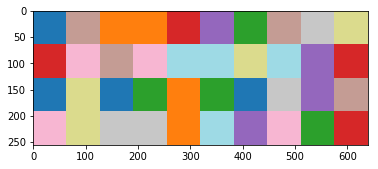

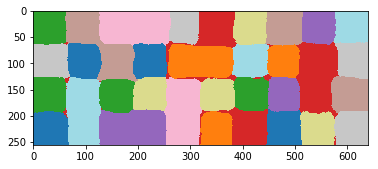

In [126]:
# Plot of predicted label map
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.show()
plt.figure()
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.show()

<p style="background-color:#adebad;">
    Compute the accuracy of the prediction for each texture, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels. Plot the accuracies in a bar plot (x-axis: texture id, y-axis: accuracy).
</p>

In [128]:
predict_texture = HC.predict(texture)

def postprocess(clusters=10):
    # patch is 128*128
    label_from_to_security = []
    map_from_to = np.empty(clusters)
    map_from_to.fill(-1)
    for i in range(5):
        for j in range(2):
            i_start,j_start = i*128, j*128
            i_end, j_end = 128*(i+1), 128*(j+1)
            binz = np.bincount(predict_texture[j_start:j_end, i_start:i_end].flatten())
            security = binz/np.sum(binz)
            proposed_label = np.argmax(security)
            label_from_to_security.append((proposed_label, label_map[j_start, i_start], security[proposed_label]))
            map_from_to[proposed_label] = label_map[j_start, i_start]
    return label_from_to_security, map_from_to

clusters = 10
lbl_from_to_sec, map_from_to = postprocess(clusters)
predicted_perm_label_map_new = predicted_perm_label_map.copy()
for c in range(clusters):
    predicted_perm_label_map_new[predicted_perm_label_map == c] = map_from_to[c]
            
            
            

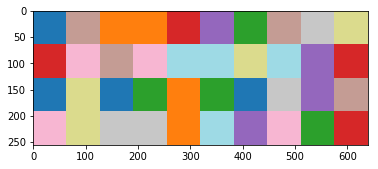

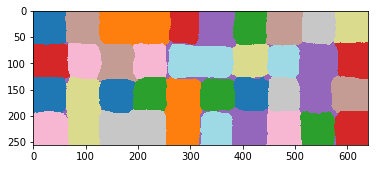

In [129]:
# Plot of predicted label map
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.show()
plt.figure()
plt.imshow(predicted_perm_label_map_new, cmap="tab20")
plt.show()

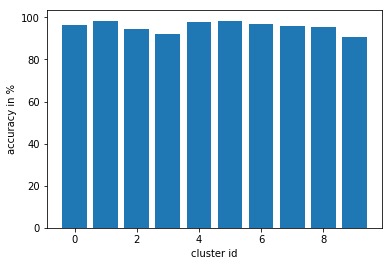

In [161]:
n_clusters = 10
accuracy = np.zeros(n_clusters)
alll = 4*64*64
for c in range(n_clusters):
    index = perm_label_map == c
    wrong = np.sum((perm_label_map[index] != predicted_perm_label_map_new[index]))
    accuracy[c] = 100./alll*(alll-wrong)

plt.figure()
plt.bar(np.arange(n_clusters), accuracy)
plt.xlabel('cluster id')
plt.ylabel('accuracy in %')
plt.show()

<h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate eight 128x128 patches, one for each texture. Plot the result.
        </li>
       
    </ul>

In [ ]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<p style="background-color:#adebad;">
    Using n_clusters=8, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix, and label the axes properly.
</p>

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete all Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering of the texture at different temperatures.
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
    <li>
        Use kmeans clustering to cluster the pixels of the texture. Set n_clusters=8, and use the local histogram vectors as features (with the best settings for n_bins and window_size that you found in problem 4).
    </li>
</ul>

<ul style="background-color:#adebad;">
    <li>
        Compute the accuracy of the kmeans prediction of perm_texture and compare it to the HC result.
    </li>
</ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the centroid histograms after fitting the texture image with the best parameter settings obtained in problem 4. Relate them to the textures by plotting the corresponding texture patch next to each histogram.
        </li>
    </ul>

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!